# Import libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import os
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering 

ModuleNotFoundError: No module named 'sklearn_extra'

# Load the dataset


In [ ]:
data = pd.read_csv('./dataset/CC GENERAL.csv')

In [ ]:
data.head()

# Exploratory Data Analysis


In [ ]:
data.info()

In [ ]:
data.isnull().sum()

In [ ]:
missing_percentage_CREDIT_LIMIT = (data['CREDIT_LIMIT'].isnull().sum() / len(data)) * 100
print(f"Porcentaje de valores faltantes en la columna 'CREDIT_LIMIT': {missing_percentage_CREDIT_LIMIT:.2f}%")

In [ ]:
missing_percentage_MINIMUM_PAYMENTS = (data['MINIMUM_PAYMENTS'].isnull().sum() / len(data)) * 100
print(f"Porcentaje de valores faltantes en la columna 'MINIMUM_PAYMENTS': {missing_percentage_MINIMUM_PAYMENTS:.2f}%")

In [ ]:
data.describe()

In [ ]:
plt.scatter(data['BALANCE'], data['CREDIT_LIMIT'])
plt.title('Relación entre BALANCE y CREDIT_LIMIT')
plt.xlabel('Balance')
plt.ylabel('Límite de Crédito')
plt.show()

In [ ]:
sns.scatterplot(x=data['BALANCE'], y=data['CREDIT_LIMIT'], hue=data['TENURE'], palette='coolwarm')
plt.title('Relación entre BALANCE y CREDIT_LIMIT por TENURE')
plt.show()

In [ ]:
sns.boxplot(x=data['TENURE'], y=data['BALANCE'])
plt.title('Distribución del BALANCE por TENURE')
plt.xlabel('Antigüedad (Meses)')
plt.ylabel('Saldo')
plt.show()

In [ ]:
sns.jointplot(x=data['PAYMENTS'], y=data['PURCHASES'])
plt.show()

In [ ]:
# AED para buscar correlación pero se debe utilizar variables numericas, el Cust_ID no lo es
#data.corr()

In [ ]:
# Filtrar las variables numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = numeric_data.corr()

In [ ]:
# Graficar el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# Data Processing


## Data Cleaning


In [ ]:
missing_columns = data.columns[data.isnull().any()]

In [ ]:
# Crear subplots para cada columna con valores faltantes
plt.figure(figsize=(10, 8))
for i, column in enumerate(missing_columns, 1):
    plt.subplot(len(missing_columns), 1, i)
    sns.histplot(data[column], kde=True, color='blue')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
#eliminar el Cust_ID
data = data.drop(columns=['CUST_ID'])

In [ ]:
# Imputar con la mediana para todas las columnas numéricas
data_imputed = data.fillna(data.median())

In [ ]:
data_imputed.isnull().sum()

In [ ]:
# Eliminar la columna CUST_ID
data_cleaned = data_imputed

In [ ]:
data_cleaned.info()

## Feature Engineering
Cree al menos 2 variables nuevas


In [ ]:
# Relación entre las compras y el límite en el crédito
data_cleaned['PURCHASES_TO_CREDIT_LIMIT'] = data_cleaned['PURCHASES'] / data_cleaned['CREDIT_LIMIT']

In [ ]:
# Realación entre los pagos y el saldo
data_cleaned['PAYMENTS_TO_BALANCE'] = data_cleaned['PAYMENTS'] / data_cleaned['BALANCE']

In [ ]:
data_cleaned[['PURCHASES_TO_CREDIT_LIMIT', 'PAYMENTS_TO_BALANCE']].head()

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data_cleaned['PURCHASES_TO_CREDIT_LIMIT'], kde=True, color='green')
plt.title('Distribución de PURCHASES_TO_CREDIT_LIMIT')
plt.xlabel('Proporción Compras/Límite de Crédito')
plt.ylabel('Frecuencia')

In [ ]:
"""plt.subplot(1, 2, 2)
sns.histplot(data_cleaned['PAYMENTS_TO_BALANCE'], kde=True, color='orange')
plt.title('Distribución de PAYMENTS_TO_BALANCE')
plt.xlabel('Proporción Pagos/Balance')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()"""

In [ ]:
# La computadora no pudo realizar la gráfica anterior así que se hizo una transformación logarítmica
data_cleaned['log_PAYMENTS_TO_BALANCE'] = np.log1p(data_cleaned['PAYMENTS_TO_BALANCE'])

In [ ]:
data_cleaned[['PURCHASES_TO_CREDIT_LIMIT', 'PAYMENTS_TO_BALANCE', 'log_PAYMENTS_TO_BALANCE']].head()

In [ ]:
plt.figure(figsize=(6, 4))
sns.stripplot(data=data_cleaned, x='PAYMENTS_TO_BALANCE', color='purple', alpha=0.6)
plt.title('Puntos de PAYMENTS_TO_BALANCE')
plt.xlabel('Proporción Pagos/Balance')
plt.show()

In [ ]:
# Graficar la distribución log-transformada
plt.figure(figsize=(6, 4))
sns.histplot(data_cleaned['log_PAYMENTS_TO_BALANCE'], kde=True, color='orange')
plt.title('Distribución Log-Transformada de PAYMENTS_TO_BALANCE')
plt.xlabel('Log(Pagos/Balance)')
plt.ylabel('Frecuencia')
plt.show()

Se crea categoria del Credit Limit para hacer una análisis categorico y no manejar la variable continua.

In [ ]:
data_cleaned[['CREDIT_LIMIT']].describe()

In [ ]:
data_cleaned['CREDIT_LIMIT_CATEGORY'] = pd.cut(
    data_cleaned['CREDIT_LIMIT'],
    bins=[0, 1500, 3000, 6000, 9000, data_cleaned['CREDIT_LIMIT'].max()],
    labels=[1, 2, 3, 4,5],
    right=True
)

In [ ]:
sns.boxplot(x=data_cleaned['CREDIT_LIMIT_CATEGORY'], y=data_cleaned['BALANCE'])
plt.title('Distribución del BALANCE por CREDIT_LIMIT_CATEGORY')
plt.xlabel('Categoria crédito')
plt.ylabel('Saldo')
plt.show()

In [ ]:
data_cleaned.columns

In [ ]:
cluster_cols = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE','PURCHASES_TRX','PAYMENTS','TENURE']


plt.figure(1, figsize=(16,10))
sns.pairplot(data=data_cleaned[cluster_cols+['CREDIT_LIMIT_CATEGORY']], hue='CREDIT_LIMIT_CATEGORY')
plt.show()

## Encoding


No es necesario realizar encodig. Las variables son numéricas. Hay categoricas binarias, variables continuas y categoricas ordinales. Por lo tanto los algoritmos de ml podrán interpretar correctamente.

## Scaling (if needed)


In [ ]:
all_vars = data_cleaned.columns
print(all_vars)
numeric_vars = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'PURCHASES_TO_CREDIT_LIMIT', 'CREDIT_LIMIT_CATEGORY']

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Crear un transformer para las columnas numéricas (escalado)
numeric_transformer = MinMaxScaler()

# Crear un ColumnTransformer que aplique el escalado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_vars),
    ])

In [ ]:
# Ajustar y transformar los datos con el preprocesador
data_preprocessed = preprocessor.fit_transform(data_cleaned)

# Mostrar los datos preprocesados
print(data_preprocessed)

In [ ]:
# Crear el nuevo DataFrame con los datos preprocesados
df_preprocessed = pd.DataFrame(data_preprocessed, columns=numeric_vars)

# Mostrar el nuevo DataFrame
print("DataFrame preprocesado:")
print(df_preprocessed)

## # Train model/Tune hyperparameters 

Explique el criterio utilizado

In [ ]:
# Método del Codo
sse = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_preprocessed)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_preprocessed, kmeans.labels_))

In [ ]:
# Gráfico del método del Codo
plt.figure(figsize=(10, 6))
plt.plot(K, sse, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Método del Codo para encontrar el número óptimo de clusters')
plt.show()

# Gráfico del Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes K')
plt.show()

In [ ]:
# Aplicar KMeans y K-Medoids (K-Medians)
optimal_k = 3  # Elegido basado en los gráficos

# Aplicar KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(df_preprocessed)

# Aplicar K-Medoids (aproximación a K-Medians)
kmedoids = KMedoids(n_clusters=optimal_k, random_state=42)
kmedoids_labels = kmedoids.fit_predict(df_preprocessed)

In [ ]:
kmeans_silhouette = silhouette_score(df_preprocessed, kmeans_labels)
kmedoids_silhouette = silhouette_score(df_preprocessed, kmedoids_labels)

# Obtener la inercia para KMeans
kmeans_inertia = kmeans.inertia_

# Para KMedoids, calculamos la suma de distancias (similar a la inercia en KMeans)
kmedoids_inertia = kmedoids.inertia_

# Mostrar los resultados
print(f"KMeans - Silhouette Score: {kmeans_silhouette}")
print(f"KMeans - Inercia (SSE): {kmeans_inertia}")
print(f"KMedoids - Silhouette Score: {kmedoids_silhouette}")
print(f"KMedoids - Inercia (Suma de distancias): {kmedoids_inertia}")

El modelo de clusterización con mejores indicadores para estas observaciones es el KMeans. Y se utilizan 3 clusters.

In [ ]:
# Categorical variable distribution among clusters
df_preprocessed['KMeans_Cluster'] = kmeans_labels

In [ ]:
sns.countplot(data=df_preprocessed, x='KMeans_Cluster')
plt.title('Distribution Among Clusters')
plt.show()

In [ ]:
# Numerical variable distribution among clusters
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
cols = ['BALANCE', 'PURCHASES', 'PAYMENTS']

# Crear cada gráfico
for i in range(len(cols)):
    sns.boxplot(data=df_preprocessed, x='KMeans_Cluster', y=cols[i], ax=axs[i])

# Título y ajustes
fig.suptitle('Numerical Variable Distribution Among Clusters')
plt.tight_layout()
plt.show()

El Kmeans no es claro para clusterizar los clientes con baje al saldo disponible. Se prueba otro modelo

In [ ]:
# Ejemplo DBSCAN

param_grid = {
    'eps': [0.9, 1.1, 1.2],  # Distancia de radio
    'min_samples': [3, 4, 6, 7]  # Número mínimo de puntos para formar un cluster
}

# Variable para almacenar los mejores resultados
best_score = -1
best_params = {}

# Búsqueda manual (Grid Search)
for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:
        # Definir el modelo con los parámetros actuales
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Ajustar el modelo
        labels = dbscan.fit_predict(df_preprocessed)

        # Verificar que haya clusters generados, ya que DBSCAN puede generar ruido (label -1)
        if len(set(labels)) > 1:  # Necesitamos al menos 2 clusters para calcular el Silhouette Score
            # Evaluar el modelo con Silhouette Score
            score = silhouette_score(df_preprocessed, labels)

            # Guardar si es el mejor score
            if score > best_score:
                best_score = score
                best_params = {
                    'eps': eps,
                    'min_samples': min_samples
                }

# Imprimir los mejores parámetros y el mejor score
print(f"Mejores Parámetros: {best_params}")
print(f"Mejor Silhouette Score: {best_score:.4f}")


In [ ]:
# Visualización de los clusters

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Reducir las dimensiones de los datos a 2 componentes principales para visualización
pca = PCA(n_components=2)
df_reduced = pca.fit_transform(df_preprocessed)

# Ajustar DBSCAN con los mejores parámetros encontrados
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
labels = dbscan.fit_predict(df_preprocessed)

# Crear el gráfico
plt.figure(figsize=(10, 6))
unique_labels = set(labels)

# Asignar colores a cada cluster
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro para el ruido (label -1)
        col = [0, 0, 0, 1]
    
    # Filtrar datos del cluster actual
    class_member_mask = (labels == k)
    xy = df_reduced[class_member_mask]
    
    # Graficar los puntos del cluster
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

# Títulos y leyendas
plt.title('Gráfico de Clusters DBSCAN')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

Se hizo esta visualización pero no es concluyente. Los cluster tiene una forma circular.

In [ ]:
# best_model = KMeans(random_state=42,n_clusters=K)
# best_model = KMedoids(random_state=42,n_clusters=K)

# best_model = DBSCAN(**best_params)
# best_model = AgglomerativeClustering(**best_params)

In [ ]:
#best_model.fit(df_preprocessed)

In [ ]:
# Crear el clustering jerárquico, método 'complete'
data_cluster = df_preprocessed
linked = linkage(data_cluster, method='complete')

# Graficar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',  # orientación del dendrograma
           distance_sort='descending',  # ordenar por distancia
           show_leaf_counts=True)  # mostrar número de puntos en cada cluster
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

# Clustering jerárquico con AgglomerativeClustering de sklearn
n_clusters = 3
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
cluster_labels = hierarchical_clustering.fit_predict(data_cluster)

# Añadir los labels al DataFrame
data_cluster['Cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_cluster, x=data_cluster.columns[0], y=data_cluster.columns[1], hue='Cluster', palette='viridis')
plt.title('Clusters usando Clustering Jerárquico (Complete Linkage)')
plt.xlabel(data_cluster.columns[0])
plt.ylabel(data_cluster.columns[1])
plt.show()

# Visualization of clusters

NameError: name 'data_cluster' is not defined

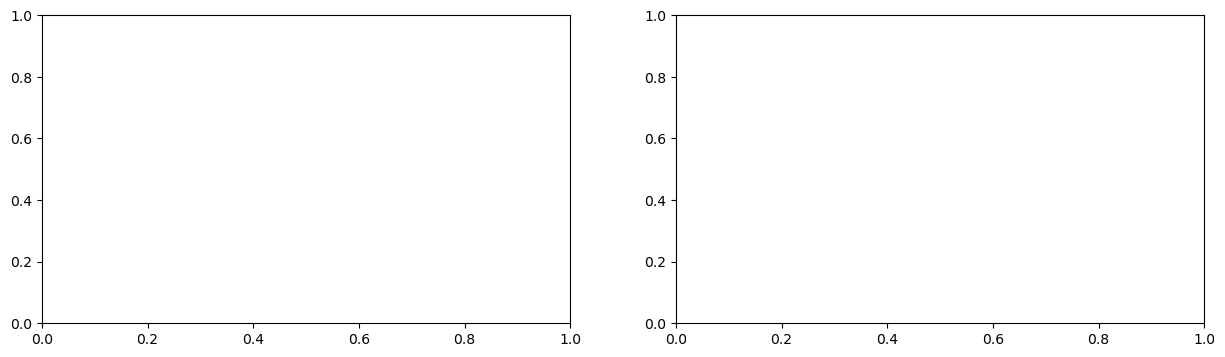

In [2]:
# Numerical variable distribution among clusters
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
cols = ['BALANCE', 'PURCHASES']
for i in range(len(cols)):
    sns.boxplot(data=data_cluster, x='Cluster', y=cols[i], ax=axs[i])
fig.suptitle('Numerical Variable Distribution Among Clusters')
plt.tight_layout()
plt.show()

# Interpretation of clusters

Cluster 0. Clientes con saldo disponible alto y score de compras alto
Cluster 1. Clientes con saldo disponible bajo y score de compras medio
Cluster 2. Clientes con saldo disponible medio y score de compras bajo